In [13]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


Define the Device Class

In [14]:
class Device:
    def __init__(self, env, name, trust_level, is_authorized, location):
        self.env = env
        self.name = name
        self.trust_level = trust_level
        self.is_authorized = is_authorized
        self.location = location
        self.action = env.process(self.run())
        self.access_denied = 0
        self.false_positive = 0
        self.false_negative = 0
        self.anomalies_detected = 0
        self.response_time = []
        self.activity_log = []

    def run(self):
        while True:
            start_time = self.env.now
            activity = random.gauss(50, 10)
            self.activity_log.append(activity)
            if not self.verify():
                self.access_denied += 1
                if self.is_authorized:
                    self.false_positive += 1
            else:
                if not self.is_authorized:
                    self.false_negative += 1
                if self.detect_anomaly(activity):
                    detection_time = self.env.now - start_time
                    self.response_time.append(detection_time)
                    self.anomalies_detected += 1
            yield self.env.timeout(random.randint(1, 3))

    def verify(self):
        return self.trust_level >= 50

    def detect_anomaly(self, activity):
        return False  # Placeholder for anomaly detection logic


Define Contextual Factor Calculation Function

In [15]:
def calculate_contextual_factor(device):
    location_factor = 0
    time_factor = 0
    activity_factor = 0

    # Location-based trust
    trusted_locations = ['office', 'home']
    if device.location in trusted_locations:
        location_factor = 5
    else:
        location_factor = -5

    # Time-based trust
    current_hour = device.env.now % 24  # Simplified time calculation
    if 9 <= current_hour <= 17:  # Regular business hours
        time_factor = 2
    else:
        time_factor = -2

    # Activity-based trust
    expected_activity_range = (40, 60)
    last_activity = device.activity_log[-1] if device.activity_log else 50
    if expected_activity_range[0] <= last_activity <= expected_activity_range[1]:
        activity_factor = 3
    else:
        activity_factor = -3

    # Sum of contextual factors
    contextual_factor = location_factor + time_factor + activity_factor
    return contextual_factor


Define Dynamic Trust Assessment Function

In [16]:
def dynamic_trust_assessment(device):
    behavioral_factor = -5 if device.detect_anomaly(device.activity_log[-1]) else 5
    historical_factor = 0 if len(device.activity_log) < 10 else (sum(device.activity_log[-10:]) / 10 - 50) / 10
    contextual_factor = calculate_contextual_factor(device)

    new_trust_level = device.trust_level + 0.6 * behavioral_factor + 0.3 * historical_factor + 0.1 * contextual_factor
    device.trust_level = max(0, min(100, new_trust_level))


Define Simulation Function

In [17]:
def run_simulation(env, devices):
    while True:
        for device in devices:
            dynamic_trust_assessment(device)
        yield env.timeout(1)


 Define Main Simulation Loop

In [18]:
def simulate(env, devices, simulation_time=100):
    env.process(run_simulation(env, devices))
    env.run(until=simulation_time)
    return devices

env = simpy.Environment()
devices = [Device(env, f'{i}', random.randint(30, 70), random.choice([True, False]), random.choice(['office', 'home', 'public'])) for i in range(10)]
simulated_devices = simulate(env, devices)


Train Anomaly Detector

In [19]:
def train_anomaly_detector(devices):
    activity_data = []
    for device in devices:
        activity_data.extend(device.activity_log)
    activity_data = np.array(activity_data).reshape(-1, 1)
    model = IsolationForest(contamination=0.1)
    model.fit(activity_data)
    return model

anomaly_detector = train_anomaly_detector(simulated_devices)


Assign Enhanced Detect Anomaly Method

In [20]:
def enhanced_detect_anomaly(device, model):
    last_activity = np.array([device.activity_log[-1]]).reshape(1, -1)
    prediction = model.predict(last_activity)
    return prediction == -1  # -1 indicates anomaly

for device in simulated_devices:
    device.detect_anomaly = lambda activity, d=device: enhanced_detect_anomaly(d, anomaly_detector)


 Data Collection and Visualization

In [23]:
data = {
    "Device": [device.name for device in simulated_devices],
    "Access Denied": [device.access_denied for device in simulated_devices],
    "False Positives": [device.false_positive for device in simulated_devices],
    "False Negatives": [device.false_negative for device in simulated_devices],
    "Anomalies Detected": [device.anomalies_detected for device in simulated_devices],
}

df = pd.DataFrame(data)
print(df)


  Device  Access Denied  False Positives  False Negatives  Anomalies Detected
0      0              2                2                0                   0
1      1              3                3                0                   0
2      2              1                1                0                   0
3      3              2                2                0                   0
4      4              0                0               51                   0
5      5              0                0                0                   0
6      6              0                0               47                   0
7      7              3                0               45                   0
8      8              0                0                0                   0
9      9              2                2                0                   0


Plot Results

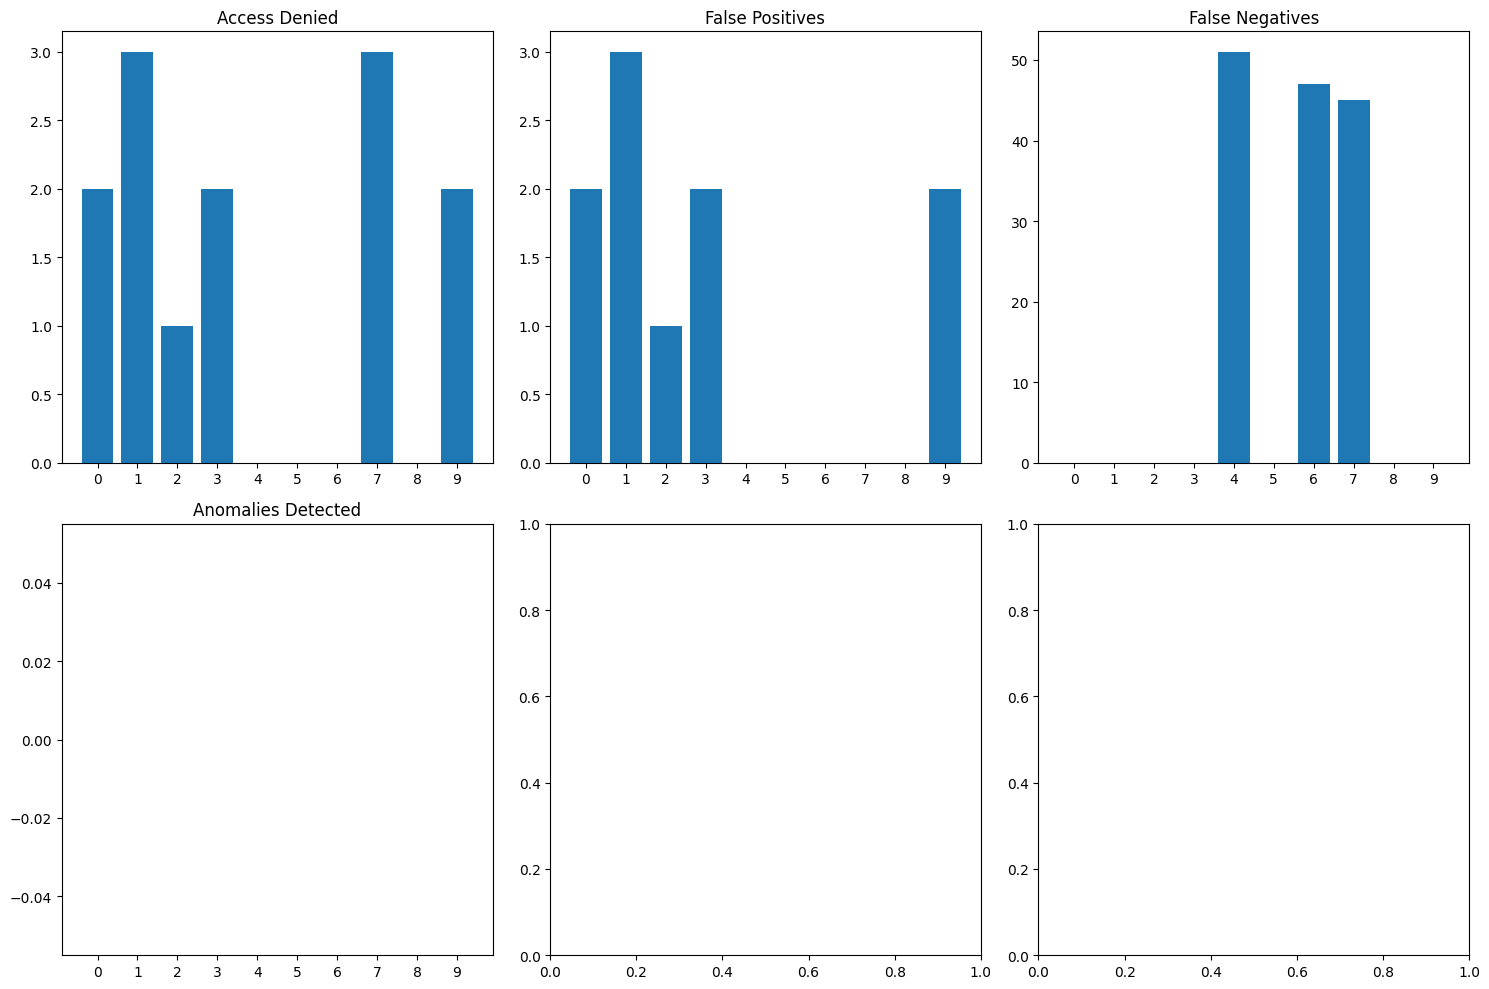

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].bar(df['Device'], df['Access Denied'])
axs[0, 0].set_title('Access Denied')

axs[0, 1].bar(df['Device'], df['False Positives'])
axs[0, 1].set_title('False Positives')

axs[0, 2].bar(df['Device'], df['False Negatives'])
axs[0, 2].set_title('False Negatives')

axs[1, 0].bar(df['Device'], df['Anomalies Detected'])
axs[1, 0].set_title('Anomalies Detected')


plt.tight_layout()
plt.show()


explanation

Access Denied
Chart Explanation:

This chart shows how many times each device was denied access.
If a device's trust level is too low (below 50), it can't get access.<br>
Does it Make Sense?

Devices with low trust levels should have higher access denied counts.
Devices with high trust levels should have lower access denied counts.
<br>False Positives
Chart Explanation:

This chart shows how many times an authorized device (one that should have access) was wrongly denied access.
A false positive is when a device is mistakenly not trusted even though it should be.
<br>Does it Make Sense?

There should be fewer false positives, especially if the trust system is working well.
Authorized devices should mostly have access and only be denied rarely.
False Negatives
Chart Explanation:

This chart shows how many times an unauthorized device (one that should not have access) was wrongly allowed access.
A false negative is when a device is mistakenly trusted even though it shouldn't be.
<br>Does it Make Sense?

There should be fewer false negatives, indicating that unauthorized devices are rarely allowed access.
If a device shouldn't be trusted, it should mostly be denied access.
Anomalies Detected
Chart Explanation:

This chart shows how many times an anomaly (unusual or unexpected behavior) was detected for each device.
Anomalies could mean that something strange or suspicious is happening with the device.
<br>Does it Make Sense?

Devices that often show unusual behavior should have more anomalies detected.
The anomaly detection system should be able to catch these unusual behaviors reliably.
Overall Sense Check
Access Denied: If a device has a low trust level, it should have higher access denied counts, and the chart should reflect that.
False Positives: There should be fewer false positives, meaning authorized devices are usually getting the access they deserve.
False Negatives: There should be fewer false negatives, meaning unauthorized devices are mostly being denied access.
Anomalies Detected: The chart should show more anomalies for devices that exhibit unusual or suspicious behavior.
